<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/satellite_imagery/data_acquisition_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="font-size: 1em; padding: 0; margin: 0;">

<tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #182AEB; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #ffffff;">Deep Learning </span> for Satellite Image Classification (Manning Publications)</span><br/>by <em>Daniel Buscombe</em> </strong><br/><br/>
        <strong>> Chapter 2: Data Acquisition and Pre-Processing </strong><br/>
    </p>           
        
<p style="border: 1px solid #ff5733; border-left: 15px solid #ff5733; padding: 10px; text-align:justify;">
    <strong style="color: #ff5733">What you will learn in this Part.</strong>  
    <br/>In this Part you will learn a workflow to generate datasets that you will use to eventually train and test your semantic segmentation model to detect water pixels in images of lakes. You will be training your models using the lakes category in the NWPU-RESISC45 dataset, and applying them to Sentinel-2 imagery of some of Earth's critical lakes. Like in many situations in industry, you will make your own label imagery (but you'll get a head-start with some labels already prepared for you). You will also learn how to augment image data sets for improving model training. <br/><br/>Optionally, you will be presented a workflow for automatically downloading imagery programmatically using the sentinelsat package, filering them by type, date, tile, and finally merging adjacent tiles to generate time-series of imagery over whole lakes. Following this workflow is strongly recommended for those learning how to work with satellite and other geospatial data, and also those who want to challenge themselves further by using a customized dataset over any lake on Earth.
    </p>

In [2]:
%%capture
!pip install rasterio
!pip install sentinelsat

In [4]:
!wget https://lx-common-resources.s3-us-west-2.amazonaws.com/lp-buscombe/Buscombe_liveProject_Feb2020.zip

--2021-06-01 07:13:20--  https://lx-common-resources.s3-us-west-2.amazonaws.com/lp-buscombe/Buscombe_liveProject_Feb2020.zip
Resolving lx-common-resources.s3-us-west-2.amazonaws.com (lx-common-resources.s3-us-west-2.amazonaws.com)... 52.218.128.113
Connecting to lx-common-resources.s3-us-west-2.amazonaws.com (lx-common-resources.s3-us-west-2.amazonaws.com)|52.218.128.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4714872 (4.5M) [application/zip]
Saving to: ‘Buscombe_liveProject_Feb2020.zip’

Buscombe_liveProjec 100%[===================>]   4.50M  4.15MB/s    in 1.1s    

2021-06-01 07:13:22 (4.15 MB/s) - ‘Buscombe_liveProject_Feb2020.zip’ saved [4714872/4714872]



In [5]:
!unzip Buscombe_liveProject_Feb2020.zip

Archive:  Buscombe_liveProject_Feb2020.zip
   creating: 1_GettingStarted/
  inflating: 1_GettingStarted/Part_1_GettingStarted.ipynb  
   creating: 1_GettingStarted/conda_env/
  inflating: 1_GettingStarted/conda_env/env.yml  
  inflating: 1_GettingStarted/requirements.txt  
  inflating: 1_GettingStarted/liveProject_Buscombe_Part1.docx  
   creating: 1_GettingStarted/.ipynb_checkpoints/
  inflating: 1_GettingStarted/.ipynb_checkpoints/Part_1_GettingStarted-checkpoint.ipynb  
   creating: 2_Data/
  inflating: 2_Data/Part2_DataAcquisition_PreProcessing.ipynb  
   creating: 2_Data/notebook_images/
  inflating: 2_Data/notebook_images/Picture1.png  
  inflating: 2_Data/notebook_images/Picture2.png  
  inflating: 2_Data/notebook_images/Picture3.png  
  inflating: 2_Data/poopo.geojson    
   creating: 2_Data/s2cloudless_labels/
  inflating: 2_Data/s2cloudless_labels/all_labels.json  
  inflating: 2_Data/s2cloudless_labels/aral_sea_s2cloudless-2018.json  
  inflating: 2_Data/s2cloudless_labels/b

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Data set 1: a time-series <br/> of cloudless sentinel-2 imagery</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
    Use the <a href="https://s2maps.eu/">Sentinel-2 cloudless</a> image service ("option 1") as a means to easily acquire cloudless mosaiced imagery from some of Earth's critical lakes that collectively provide drinking water to countless millions of people. You can use the website to explore and compare changes visually between 2016 and 2018 everywhere, and also 2017 for Europe only. This is the data you will be attempting to test your model (trained on another dataset that is introduced later).
</p>
<p style="border-left: 15px solid #6019D6; padding: 0 10px; text-align:justify;">
    <strong style="color: #6019D6;">Tip.</strong> 
If you use the download tool to obtain an image tile, you will see some structure in the URL. For example, 
<br/>
<a href="https://tiles.maps.eox.at/wms?service=wms&request=getmap&version=1.1.1&layers=s2cloudless-2018&bbox=10.232263646327286,-0.670557747166987,10.334917149745255,-0.5679042437490183&width=4096&height=4096&srs=epsg:4326">https://tiles.maps.eox.at/wms?service=wms&request=getmap&version=1.1.1&layers=s2cloudless-2018&bbox=10.232263646327286,-0.670557747166987,10.334917149745255,-0.5679042437490183&width=4096&height=4096&srs=epsg:4326</a>
<br/><br/>
    Let's break this down a little:
<ul>
    <li><b>https://tiles.maps.eox.at/wms?service=wms&request=getmap&version=1.1.1</b>: The root of the service that always stays the same. WMS stands for <a href="https://en.wikipedia.org/wiki/Web_Map_Service">Web Map Service</a>.</li>    
    <li><b>layers=s2cloudless2018</b>: The layer to get. Other options are <em>"s2cloudless"</em> for 2016 imagery, and <em>"s2cloudless2017"</em> for 2017 imagery (Europe only).</li>
  <li><b>bbox=10.232263646327286,-0.670557747166987,10.334917149745255,-0.5679042437490183</b>: the bounding box coordinates (region of interest) in the form south Latitude, west Longitude, north Latitude, east Longitude.</li>
  <li><b>width=4096&height=4096</b>: the width and height of the image in number of pixels</li>  
    <li><b>srs=epsg:4326</b>: the <a href="http://www.epsg-registry.org/">epsg</a> code (coordinate projection system) that pertains to the bounding box coordinates. In this example the epsg code is <a href="https://epsg.io/4326">4326</a>, which is GPS coordinates (WGS 84).</li>  
</ul>  
</p>
        </tr>
        </table>

##### Building a web scraping script to download imagery from internet servers

Now we understand the URL, we can use a program to download image time-series at a number of places programmatically. This is an example of <a href="https://en.wikipedia.org/wiki/Web_scraping">web scraping</a>

In [1]:
# define all the parameters
root = "https://tiles.maps.eox.at/wms?service=wms&request=getmap&version=1.1.1&"
layers = 'layers=s2cloudless-2018&'
bbox = 'bbox=10.232263646327286,-0.670557747166987,10.334917149745255,-0.5679042437490183&'
width = 'width=4096&'
height = 'height=4096&'
srs = 'srs=epsg:4326'

# define the output
destination = 'example_image.jpg'

#construct and print the url
url = root+layers+bbox+width+height+srs
print(url)

https://tiles.maps.eox.at/wms?service=wms&request=getmap&version=1.1.1&layers=s2cloudless-2018&bbox=10.232263646327286,-0.670557747166987,10.334917149745255,-0.5679042437490183&width=4096&height=4096&srs=epsg:4326


Use the built-in package <a href="https://docs.python.org/3/library/urllib.request.html#module-urllib.request">urllib.request</a> to download the file

In [2]:
import urllib.request
urllib.request.urlretrieve(url, destination)

('example_image.jpg', <http.client.HTTPMessage at 0x7fc293353210>)

To remove the image:

In [3]:
import os
os.remove('example_image.jpg')

Download time-series of images from 17 critically endangered lake systems:
1. <a href="https://en.wikipedia.org/wiki/Lake_Poop%C3%B3">Lake Poopo, Bolivia</a>

2. <a href="https://en.wikipedia.org/wiki/Lake_Urmia">Lake Urmia, Iran</a> 
 
3. <a href="https://en.wikipedia.org/wiki/Lake_Mead">Lake Mead</a>/<a href="https://en.wikipedia.org/wiki/Lake_Mohave">Lake Mojave</a>, USA

4. <a href="https://en.wikipedia.org/wiki/Aral_Sea">Aral sea, Kazahkstan</a>

5. <a href="https://en.wikipedia.org/wiki/Lake_Copais">Lake Copais, Greece</a>

6. <a href="https://en.wikipedia.org/wiki/Ramganga_Dam">Lake Ramganga, India</a>
 
7. <a href="https://en.wikipedia.org/wiki/Qinghai_Lake">Qinghai Lake, China</a> 

8. <a href="https://en.wikipedia.org/wiki/Salton_Sea">Salton Sea, USA</a> 

9. <a href="https://earthobservatory.nasa.gov/images/8991/drying-of-lake-faguibine-mali">Lake Faguibine, Mali</a> 
 
10. <a href="https://en.wikipedia.org/wiki/Mono_Lake">Mono Lake, USA</a> 

11. <a href="https://en.wikipedia.org/wiki/Walker_Lake_(Nevada)">Walker Lake, USA</a>

12. <a href="https://en.wikipedia.org/wiki/Lake_Balaton">Lake Balaton, Hungary</a>

13. <a href="https://en.wikipedia.org/wiki/Lake_Koroneia">Lake Koroneia, Greece</a>

14. <a href="https://en.wikipedia.org/wiki/Lake_Salda">Lake Salda, Turkey</a>

15. <a href="https://en.wikipedia.org/wiki/Lake_Burdur">Lake Burdur, Turkey</a>

16. <a href="https://en.wikipedia.org/wiki/Lake_Mendocino">Lake Mendocino, USA</a>

17. <a href="https://en.wikipedia.org/wiki/Elephant_Butte_Reservoir">Elephant Butte Reservoir, USA</a>

You can read about some of these sites and their problems in a <a href="https://www.nationalgeographic.com/magazine/2018/03/drying-lakes-climate-change-global-warming-drought/">2018 National Geographic article</a>

In [4]:
#Lake Poopo, Bolivia
site='poopo'
bbox = 'bbox=-68.66848367000537,-19.687928531849003,-66.67924128546656,-17.8774477409051&'
width = 'width=4096&'
height = 'height=4096&'
layers = ['layers=s2cloudless&', 'layers=s2cloudless-2018&']
srs = 'srs=epsg:4326'

The following function can be used to download all layers given a list of layers

In [5]:
def download_all_layers(root,layers,bbox,width,height,srs,site):
    #cycle through each layer to download
    for layer in layers:
        # construct a URL string 
        url = root+layer+bbox+width+height+srs
        #download into a filename constructed as "site_layer.jpg"
        urllib.request.urlretrieve(url, site+'_'+layer.split('=')[-1].split('&')[0]+'.jpg')

If the above function doesn't function correctly, you might find the alternative solution below useful

In [ ]:
# import requests, shutil
# def download_all_layers(root,layers,bbox,width,height,srs,site):
#     #cycle through each layer to download
#     for layer in layers:
#         # construct a URL string 
#         url = root+layer+bbox+width+height+srs
#         #download into a filename constructed as "site_layer.jpg"
#         r=requests.get(url, stream=True)
#         if r.status_code == 200:
#             with open(site+'_'+layer.split('=')[-1].split('&')[0]+'.jpg', 'wb') as f:
#                 r.raw.decode_content = True
#                 shutil.copyfileobj(r.raw, f)    
#                 del r             

Note that if the file doesn’t download due to an error, it is likely because of an unstable internet connection, you will need to run it again if it fails

In [6]:
#Use the function to download all layers at Lake Poopo
download_all_layers(root,layers,bbox,width,height,srs,site)

Now you can download imagery at the other 16 sites in turn. This will download 40 images and a total of 104 MB

In [7]:
#Lake Urmia, Iran
bbox = 'bbox=44.587725529095295,36.86436828406643,46.230181583782795,38.50682433875393&'
layers = ['layers=s2cloudless&', 'layers=s2cloudless-2017&', 'layers=s2cloudless-2018&']
download_all_layers(root,layers,bbox,width,height,srs,'urmia')

In [8]:
#Lake Mead/ Lake Mojave, USA
bbox = 'bbox=-115.42507235769445,34.94273489926993,-113.78261630300695,36.58519095395743&'
layers = ['layers=s2cloudless&','layers=s2cloudless-2018&']
download_all_layers(root,layers,bbox,width,height,srs,'mead_mojave')

In [9]:
#Aral Sea, Kazahkstan
bbox = 'bbox=58.032853536637845,43.955292007325,61.317765646012845,47.2402041167&'
download_all_layers(root,layers,bbox,width,height,srs,'aral_sea')

In [10]:
#Copais Lake, Greece
bbox = 'bbox=23.214268551013436,38.36067354565393,23.350911007068124,38.4633270490719&'
layers = ['layers=s2cloudless&', 'layers=s2cloudless-2017&', 'layers=s2cloudless-2018&']
download_all_layers(root,layers,bbox,width,height,srs,'copais')

In [11]:
#Ramganga Lake, India
bbox = 'bbox=78.63716910452058,29.468167756293038,78.91045401662996,29.673474763128976&'
layers = ['layers=s2cloudless&','layers=s2cloudless-2018&']
download_all_layers(root,layers,bbox,width,height,srs,'ramganga')

In [12]:
#Qinghai Lake, China 
bbox = 'bbox=99.56471967977474,35.70094613663666,101.20168257039974,37.34340219132416&'
download_all_layers(root,layers,bbox,width,height,srs,'qinghai')

In [13]:
#Salton Sea, USA 
bbox = 'bbox=-116.21928854749297,32.903320741965295,-115.40080710218047,33.724548769309045&'
download_all_layers(root,layers,bbox,width,height,srs,'salton_sea')

In [14]:
# Lake Faguibine, Mali
bbox = 'bbox=-4.656089323623854,14.959306189862815,-3.0191264329988536,16.601762244550315&'
width = 'width=4082&'
download_all_layers(root,layers,bbox,width,height,srs,'faguibine')

In [15]:
# Mono Lake, USA
bbox = 'bbox=-119.22357779576633,37.797192162208084,-118.81433707311008,38.20780617587996&'
download_all_layers(root,layers,bbox,width,height,srs,'mono')

In [16]:
# Walker Lake, USA
bbox = 'bbox=-118.82841344222616,38.58649115903216,-118.62379308089804,38.791798165868094&'
download_all_layers(root,layers,bbox,width,height,srs,'walker')

In [17]:
# Lake Balaton, Hungary
width = 'width=4096&'
height = 'height=3084&'
layers = ['layers=s2cloudless&', 'layers=s2cloudless-2017&', 'layers=s2cloudless-2018&']
bbox = 'bbox=17.138306471163226,46.438781725159295,18.231446119600726,47.260009752503045&'
download_all_layers(root,layers,bbox,width,height,srs,'balaton')

In [18]:
# Lake Koroneia, Greece
bbox = 'bbox=23.34167375183668,40.56321556296156,23.614958663946055,40.7685225697975&'
download_all_layers(root,layers,bbox,width,height,srs,'koroneia')

In [19]:
# Lake Salda, Turkey
width = 'width=4082&'
height = 'height=4096&'
bbox = 'bbox=29.6337346568769,37.49763563391751,29.736044837540963,37.60028913733548&'
download_all_layers(root,layers,bbox,width,height,srs,'salda')

In [20]:
# Lake Burdur, Turkey
width = 'width=4096&'
height = 'height=2312&'
bbox = 'bbox=30.008970333642345,37.6345355820376,30.373579098290783,37.83984258887354&'
download_all_layers(root,layers,bbox,width,height,srs,'burdur')

In [21]:
# Lake Mendocino, USA
width = 'width=4082&'
height = 'height=4096&'
bbox = 'bbox=-123.19613698824355,39.189371563341254,-123.14498189791152,39.24069831505024&'
layers = ['layers=s2cloudless&','layers=s2cloudless-2018&']
download_all_layers(root,layers,bbox,width,height,srs,'mendocino')

In [22]:
# Elephant Butte Reservoir, USA
bbox = 'bbox=-107.23803910498334,33.14614806405013,-107.13572892431928,33.2488015674681&'
download_all_layers(root,layers,bbox,width,height,srs,'elephant_butte')

##### Organizing the downloaded files

Now you have downloaded imagery from every site, use the ```glob``` and ```shutil``` libraries to clean up. Change the name of the 2016 imagery so it has the ```-2016``` string in the filename.

It will become clear why we put the imagery into the subfolder ```data``` in Part 3

In [23]:
## create a directory to move the images into. It is wrapped in a "try:except" loop 
## in case you have run this cell before and want to avoid errors
try:
    os.mkdir('s2cloudless_imagery')
    os.mkdir('s2cloudless_imagery'+os.sep+'data')
except:
    pass

In [24]:
import shutil, glob, os
# cycle through each jpg image in the current directory
try:
    for f in glob.glob('*.jpg'):
        #move to the new directory
        if f.endswith('s2cloudless.jpg'): #2016 imagery
            shutil.move(f, 's2cloudless_imagery'+os.sep+'data'+os.sep+f.replace('s2cloudless.jpg','s2cloudless-2016.jpg'))
        else: #2017 or 2018 imagery
            shutil.move(f, 's2cloudless_imagery'+os.sep+'data')
except:
    pass        

##### Reading and displaying the files

Let's take a look at the images. First read the images into a list organized by site

In [25]:
# get a sorted list of all jpg files
files = sorted(glob.glob('s2cloudless_imagery'+os.sep+'data'+os.sep+'*.jpg'))
# define a list of sites
sites = ['aral_sea','balaton','burdur','copais','elephant_butte',
         'faguibine','koroneia','mead_mojave','mendocino','mono',
         'poopo','qinghai','ramganga','salda','urmia','walker']

In [26]:
#allocate F which will contain a list of file name lists
F = []; F_arrays = []
#cycle through each of the 17 sites
for site in sites:
    # append those files at each site
    F.append([f for f in files if f.startswith('s2cloudless_imagery'+os.sep+'data'+os.sep+site)])

In [27]:
F

[['s2cloudless_imagery/data/aral_sea_s2cloudless-2016.jpg',
  's2cloudless_imagery/data/aral_sea_s2cloudless-2018.jpg'],
 ['s2cloudless_imagery/data/balaton_s2cloudless-2016.jpg',
  's2cloudless_imagery/data/balaton_s2cloudless-2017.jpg',
  's2cloudless_imagery/data/balaton_s2cloudless-2018.jpg'],
 ['s2cloudless_imagery/data/burdur_s2cloudless-2016.jpg',
  's2cloudless_imagery/data/burdur_s2cloudless-2017.jpg',
  's2cloudless_imagery/data/burdur_s2cloudless-2018.jpg'],
 ['s2cloudless_imagery/data/copais_s2cloudless-2016.jpg',
  's2cloudless_imagery/data/copais_s2cloudless-2017.jpg',
  's2cloudless_imagery/data/copais_s2cloudless-2018.jpg'],
 ['s2cloudless_imagery/data/elephant_butte_s2cloudless-2016.jpg',
  's2cloudless_imagery/data/elephant_butte_s2cloudless-2018.jpg'],
 ['s2cloudless_imagery/data/faguibine_s2cloudless-2016.jpg',
  's2cloudless_imagery/data/faguibine_s2cloudless-2018.jpg'],
 ['s2cloudless_imagery/data/koroneia_s2cloudless-2016.jpg',
  's2cloudless_imagery/data/koronei

Use rasterio to import the image data into a new list of image arrays

In [31]:
import rasterio

In [32]:
F_arrays = [] #initialize empty list
for f in F: #cycle through sites
    tmp = [] #make a temporary empty list
    for i in f: #cycle through files at each site
        with rasterio.open(i) as dataset: #open the file
            tmp.append(dataset.read().T) #read in and transpose channels
    F_arrays.append(tmp) #add to F_arrays

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [34]:
#F_arrays

Plot the first and last images at each site, side by side

In [35]:
import matplotlib.pyplot as plt

Show the first 5 sites

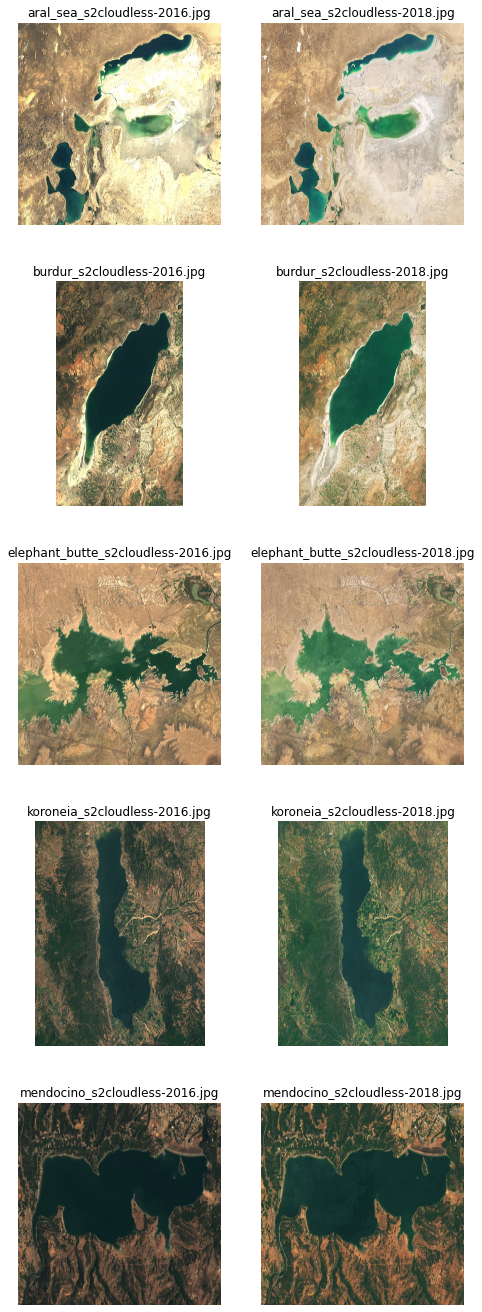

In [36]:
%matplotlib inline

# visualize some of the examples
fig = plt.figure(figsize=(8,24))
for i in range(1,10,2):
    plt.subplot(5,2,i)
    plt.imshow(F_arrays[i-1][0])
    plt.title(F[i-1][0].split(os.sep)[-1])
    plt.axis('off')
    plt.subplot(5,2,i+1)
    plt.imshow(F_arrays[i-1][-1])
    plt.title(F[i-1][-1].split(os.sep)[-1])
    plt.axis('off')
plt.show()

Plot the next 5 sites

In [37]:
F_arrays = F_arrays[5:]

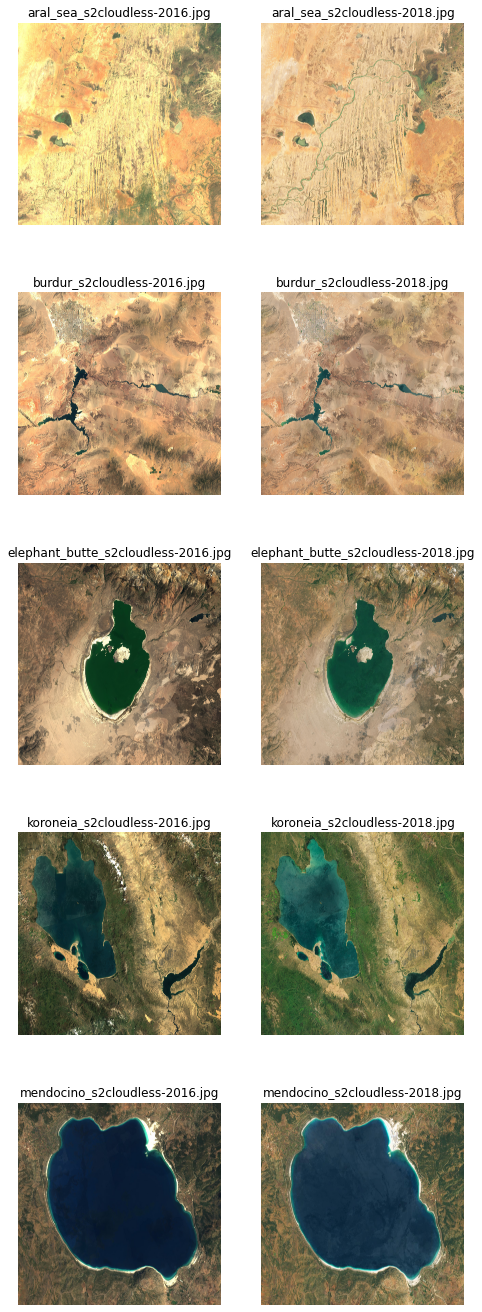

In [38]:
fig = plt.figure(figsize=(8,24))
for i in range(1,10,2):
    plt.subplot(5,2,i)
    plt.imshow(F_arrays[i-1][0])
    plt.title(F[i-1][0].split(os.sep)[-1])
    plt.axis('off')
    plt.subplot(5,2,i+1)
    plt.imshow(F_arrays[i-1][-1])
    plt.title(F[i-1][-1].split(os.sep)[-1])
    plt.axis('off')
plt.show()

As you can see, there is a considerable amount of variability in color, hue, and texture in water and surrounding land pixels. 

> Going further: how many other lakes can you find that show a noticeable change between 2016 and 2018?

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Data set 2: NWPU-RESISC45 <br/> dataset of land covers and uses</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
The Northwestern Polytechnical University (NWPU) REmote Sensing Image Scene Classification (RESISC) project has created <a href="http://www.drweiscience.com/people/JunweiHan/NWPU-RESISC45.html">NWPU-RESISC45</a>, a publicly available benchmark dataset containing 31,500 high-resolution images from Google Earth imagery, in 45 scene classes with 700 images in each class. 
</p>
<p style="border-left: 15px solid #6019D6; padding: 0 10px; text-align:justify;">
    <strong style="color: #6019D6;">Tip.</strong> 
    The dataset is described in <a href="https://arxiv.org/abs/1703.00121">this paper</a> and is also available as a tensorflow <a href="https://www.tensorflow.org/datasets/catalog/resisc45">built-in dataset</a>
</p>
        </tr>
        </table>

##### Download the dataset from google drive. 

Warning, this will download 415 MB. We saw this function for downloading a file in the previous Part

In [39]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

Download the google drive file into a zipped folder on your computer called ```NWPU_images.zip```. This should be 405 MB

In [40]:
file_id = '14kkcuU6wd9UMvjaDrg3PNI-e_voCi8HL'
destination = 'NWPU_images.zip'
download_file_from_google_drive(file_id, destination)

#### Using system commands to work with the files

Unzip the folder (this may take a few minutes) as a new folder called ```images```

In [41]:
import zipfile
def unzip_nwpu(f):
    """
    f = file to be unzipped
    """    
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall()

In [42]:
unzip_nwpu(destination)

Load file sysem utilities for moving and deleting files (```os``` and ```shutil```).

In [43]:
import shutil, os

Rename the ```images``` directory

In [44]:
try:
    os.rename('images','nwpu_images')
except:
    pass

Remove non-lake directories that we won't need. First find all subdirectories (except the first, which is the parent directory)

In [45]:
subdirecs = [x[0] for x in os.walk('nwpu_images')][1:]

In [46]:
subdirecs

['nwpu_images/dense_residential',
 'nwpu_images/palace',
 'nwpu_images/mountain',
 'nwpu_images/medium_residential',
 'nwpu_images/harbor',
 'nwpu_images/terrace',
 'nwpu_images/airport',
 'nwpu_images/basketball_court',
 'nwpu_images/tennis_court',
 'nwpu_images/industrial_area',
 'nwpu_images/lake',
 'nwpu_images/forest',
 'nwpu_images/beach',
 'nwpu_images/railway_station',
 'nwpu_images/railway',
 'nwpu_images/desert',
 'nwpu_images/stadium',
 'nwpu_images/rectangular_farmland',
 'nwpu_images/circular_farmland',
 'nwpu_images/ship',
 'nwpu_images/baseball_diamond',
 'nwpu_images/bridge',
 'nwpu_images/airplane',
 'nwpu_images/runway',
 'nwpu_images/sparse_residential',
 'nwpu_images/meadow',
 'nwpu_images/freeway',
 'nwpu_images/roundabout',
 'nwpu_images/commercial_area',
 'nwpu_images/intersection',
 'nwpu_images/cloud',
 'nwpu_images/mobile_home_park',
 'nwpu_images/wetland',
 'nwpu_images/thermal_power_station',
 'nwpu_images/snowberg',
 'nwpu_images/ground_track_field',
 'nwpu

then get a list of all subdirectories that do not contain the word "lake"

In [47]:
to_delete = [s for s in subdirecs if 'lake' not in s]

Use ```shutil.rmtree``` to delete the imagery

In [48]:
for k in to_delete:
    shutil.rmtree(k, ignore_errors=True) 

Finally, rename the subdirectory, for consistency with dataset 1. It will become apparent why we use the ```data``` subdirectory in Part 3

In [49]:
os.rename('nwpu_images'+os.sep+'lake','nwpu_images'+os.sep+'data')

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Creating your own  <br/> label data</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
Label images can be time-consuming to create but creation of accurate pixelwise label images is necessary for any semantic segmentation project. The <a href+"https://www.makesense.ai/">https://www.makesense.ai/</a> utility is an efficient and relatively simple way to generate image labels (for various applications; not just semantic segmantation). A <a href="https://www.json.org/">json</a> format file is provided that contains labels for each of the 40 sentinel-2 cloudless images created earlier in this Part, intended for testing the deep learning water classifier. 
</p>
<p style="border-left: 15px solid #6019D6; padding: 0 10px; text-align:justify;">
    <strong style="color: #6019D6;">Tip.</strong> 
You will be expected to create your own labels for the training data set (NWPU-RESISC45, and any other data sets you create by following the "Going further" stream), perhaps in groups for time-efficiency. The following describes workflows for reading, writing, editing and merging json format files created by using <a href+"https://www.makesense.ai/">https://www.makesense.ai/</a>. Select "Get Started" >> Load your images (best not to load too many at once) >> Select "Object Detection" >> create a label "water" >> Select "start project then "I'm going on my own". Now you should see your uploaded images and the labeling tools. Remember to use the "Polygon" tool, and to "export labels" when you are done.
</p>
        </tr>
        </table>

##### Importing a json label file with one image annotation

Import the json label file and extract the polygon coordinates

In [54]:
!zip -r s2cloudless_imagery.zip s2cloudless_imagery/ 

  adding: s2cloudless_imagery/ (stored 0%)
  adding: s2cloudless_imagery/data/ (stored 0%)
  adding: s2cloudless_imagery/data/qinghai_s2cloudless-2016.jpg (deflated 0%)
  adding: s2cloudless_imagery/data/mead_mojave_s2cloudless-2018.jpg (deflated 0%)
  adding: s2cloudless_imagery/data/poopo_s2cloudless-2016.jpg (deflated 0%)
  adding: s2cloudless_imagery/data/copais_s2cloudless-2018.jpg (deflated 0%)
  adding: s2cloudless_imagery/data/koroneia_s2cloudless-2018.jpg (deflated 0%)
  adding: s2cloudless_imagery/data/aral_sea_s2cloudless-2016.jpg (deflated 0%)
  adding: s2cloudless_imagery/data/mono_s2cloudless-2016.jpg (deflated 0%)
  adding: s2cloudless_imagery/data/balaton_s2cloudless-2018.jpg (deflated 0%)
  adding: s2cloudless_imagery/data/salton_sea_s2cloudless-2018.jpg (deflated 0%)
  adding: s2cloudless_imagery/data/elephant_butte_s2cloudless-2016.jpg (deflated 0%)
  adding: s2cloudless_imagery/data/faguibine_s2cloudless-2018.jpg (deflated 0%)
  adding: s2cloudless_imagery/data/koro

In [58]:
import json, os
import numpy as np
#json_file = 's2cloudless_labels'+os.sep+'balaton_s2cloudless-2018.json'
json_file = "/content/2_Data/s2cloudless_labels/balaton_s2cloudless-2018.json"

The VGG json format is simply a text format for containing image annotation data in a human-readable and consistent way

In [59]:
data = json.load(open(json_file))
data = data['balaton_s2cloudless-2018.jpg']

In [60]:
x = data['regions']['0']['shape_attributes']['all_points_x']
y = data['regions']['0']['shape_attributes']['all_points_y']

Read the image, transpose its channels and print the shape to screen

In [65]:
import rasterio
with rasterio.open('s2cloudless_imagery'+os.sep+'data'+os.sep+'balaton_s2cloudless-2018.jpg') as dataset:
    im = dataset.read().T
print(np.shape(im))

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(4096, 3084, 3)


The `.T` transpose is required because the channels are ordered BGR wheras our visual cortex responds to RGB ordering, which we call the visible band spectrum

In [66]:
import matplotlib.pyplot as plt

Plot the polygon over the image

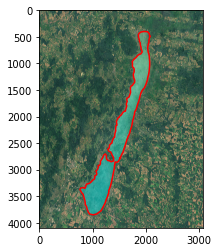

In [67]:
%matplotlib inline
plt.imshow(im)
plt.plot(y,x,'r')

##### Loading json files with multiple polygons for one image

In [69]:
json_aral_sea_path = "/content/2_Data/s2cloudless_labels/aral_sea_s2cloudless-2018.json"
data = json.load(open(json_aral_sea_path))
data = data['aral_sea_s2cloudless-2018.jpg']

In [70]:
x1 = data['regions']['0']['shape_attributes']['all_points_x']
y1 = data['regions']['0']['shape_attributes']['all_points_y']

x2 = data['regions']['1']['shape_attributes']['all_points_x']
y2 = data['regions']['1']['shape_attributes']['all_points_y']

x3 = data['regions']['2']['shape_attributes']['all_points_x']
y3 = data['regions']['2']['shape_attributes']['all_points_y']

x4 = data['regions']['3']['shape_attributes']['all_points_x']
y4 = data['regions']['3']['shape_attributes']['all_points_y']

In [71]:
with rasterio.open('s2cloudless_imagery'+os.sep+'data'+os.sep+'aral_sea_s2cloudless-2018.jpg') as dataset:
    im = dataset.read().T

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


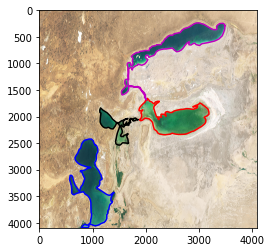

In [72]:
%matplotlib inline
plt.imshow(im)
plt.plot(y1,x1,'r')
plt.plot(y2,x2,'k')
plt.plot(y3,x3,'b')
plt.plot(y4,x4,'m')

##### Working with VGG-json format data

Create a list containing the contents of two json files that you wish to merge

In [73]:
json_aral_sea_path = "/content/2_Data/s2cloudless_labels/aral_sea_s2cloudless-2018.json"
json_urmia_path = "/content/2_Data/s2cloudless_labels/urmia_s2cloudless-2016.json"
data = []
data.append(json.load(open(json_aral_sea_path)))
data.append(json.load(open(json_urmia_path)))

Merge the list of dictionaries into a single dictionary

In [74]:
data_merged = {}
for d in data:
    data_merged.update(d)

Verify by printing the image names

In [75]:
images = sorted(data_merged.keys())
print(images)

['aral_sea_s2cloudless-2016.jpg', 'aral_sea_s2cloudless-2018.jpg', 'balaton_s2cloudless-2016.jpg', 'balaton_s2cloudless-2017.jpg', 'balaton_s2cloudless-2018.jpg', 'urmia_s2cloudless-2016.jpg']


Let's say the image names changed and you had to update the json information with the new image names. One potential solution is illustrated below:

In [76]:
new_images = []
for image in images:
    if image.startswith('aral'):
        image = image.replace('aral', 'Aral')
        new_images.append(image)
    elif image.startswith('balaton'):
        image = image.replace('balaton', 'Site0001')
        new_images.append(image)
    else:
        new_images.append(image)
print(new_images)        

['Aral_sea_s2cloudless-2016.jpg', 'Aral_sea_s2cloudless-2018.jpg', 'Site0001_s2cloudless-2016.jpg', 'Site0001_s2cloudless-2017.jpg', 'Site0001_s2cloudless-2018.jpg', 'urmia_s2cloudless-2016.jpg']


Then you could replace the old image names (keys) with the new ones 

In [77]:
for old_key, new_key in zip(images, new_images):
    data_merged[new_key] = data_merged.pop(old_key)
print(data_merged.keys())

dict_keys(['Aral_sea_s2cloudless-2016.jpg', 'Aral_sea_s2cloudless-2018.jpg', 'Site0001_s2cloudless-2016.jpg', 'Site0001_s2cloudless-2017.jpg', 'Site0001_s2cloudless-2018.jpg', 'urmia_s2cloudless-2016.jpg'])


The following code writes the merged data back out to file

In [79]:
merged_path = "/content/2_Data/s2cloudless_labels/merged.json"
with open(merged_path,'w') as f:
    json.dump(data_merged, f)

##### Loading json files with multiple polygons for several images

In [81]:
all_labels_json = "/content/2_Data/s2cloudless_labels/all_labels.json"
data = json.load(open(all_labels_json))
images = sorted(data.keys())
print(images)
print(len(images))

['aral_sea_s2cloudless-2016.jpg', 'aral_sea_s2cloudless-2018.jpg', 'balaton_s2cloudless-2016.jpg', 'balaton_s2cloudless-2017.jpg', 'balaton_s2cloudless-2018.jpg', 'burdur_s2cloudless-2016.jpg', 'burdur_s2cloudless-2017.jpg', 'burdur_s2cloudless-2018.jpg', 'copais_s2cloudless-2016.jpg', 'copais_s2cloudless-2017.jpg', 'copais_s2cloudless-2018.jpg', 'elephant_butte_s2cloudless-2016.jpg', 'elephant_butte_s2cloudless-2018.jpg', 'faguibine_s2cloudless-2016.jpg', 'faguibine_s2cloudless-2018.jpg', 'koroneia_s2cloudless-2016.jpg', 'koroneia_s2cloudless-2017.jpg', 'koroneia_s2cloudless-2018.jpg', 'mead_mojave_s2cloudless-2016.jpg', 'mead_mojave_s2cloudless-2018.jpg', 'mendocino_s2cloudless-2016.jpg', 'mendocino_s2cloudless-2018.jpg', 'mono_s2cloudless-2016.jpg', 'mono_s2cloudless-2018.jpg', 'poopo_s2cloudless-2016.jpg', 'poopo_s2cloudless-2018.jpg', 'qinghai_s2cloudless-2016.jpg', 'qinghai_s2cloudless-2018.jpg', 'ramganga_s2cloudless-2016.jpg', 'ramganga_s2cloudless-2018.jpg', 'salda_s2cloudless

Load all images into memory

In [82]:
all_images = []
for image in images:
    with rasterio.open('s2cloudless_imagery'+os.sep+'data'+os.sep+image) as dataset:
        all_images.append(dataset.read().T)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Create a function to show an image and make/show polygon vectors on top

In [83]:
def make_plot(data, images, i):
    X = []; Y = [] #pre-allocate lists to fill in a for loop
    for k in data[images[i]]['regions']: #cycle through each polygon
        # get the x and y points from the dictionary
        X.append(data[images[i]]['regions'][k]['shape_attributes']['all_points_x'])
        Y.append(data[images[i]]['regions'][k]['shape_attributes']['all_points_y'])
    #make a plot of the image, create a title (the image filename)    
    plt.imshow(all_images[i])
    plt.title(images[i])
    # plot each polygon and turn the axes off
    for k in range(len(X)):
        plt.plot(Y[k],X[k])
    plt.axis('off')
    return Y,X #image coordinates are flipped relative to json coordinates

Make a plot of the "0th" lake in the list

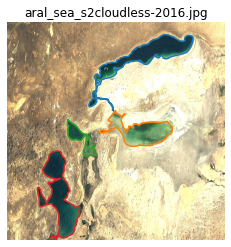

In [84]:
X,Y = make_plot(data, images, 0)

Make a plot of the "10th" lake in the list

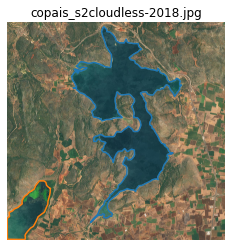

In [85]:
X,Y = make_plot(data, images, 10)

In [86]:
i = 11

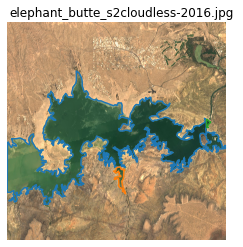

In [87]:
X,Y = make_plot(data, images, i)

##### Create a label image or 'mask' from label polygons 

In [88]:
# import some drawing tools from PIL
from PIL import Image, ImageDraw

In [89]:
# get the dimensions of the image
nx, ny, nz = np.shape(all_images[i])
mask = np.zeros((ny,nx))
    
for x,y in zip(X,Y):
    # the ImageDraw.Draw().polygon function we will use to create the mask
    # requires the x's and y's are interweaved, which is what the following
    # one-liner does    
    polygon = np.vstack((x,y)).reshape((-1,),order='F').tolist()

    # create a mask image of the right size and infill according to the polygon
    if nx>ny:
        x,y = y,x 
        img = Image.new('L', (ny, nx), 0)
    #elif ny>nx:
    #    x,y = y,x 
    #    img = Image.new('L', (ny, nx), 0)            
    else:
        img = Image.new('L', (nx, ny), 0)

    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    # turn into a numpy array
    m = np.array(img)
    mask = mask + m

Take a look!

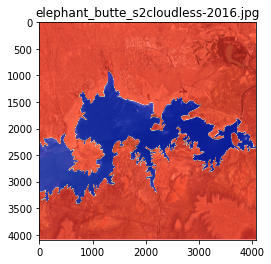

In [90]:
plt.imshow(all_images[i])
plt.title(images[i])
plt.imshow(mask, cmap='bwr_r', alpha=0.5)

Matplotlib can be used to save the jpg image

In [91]:
import matplotlib
matplotlib.image.imsave("mask.jpg", mask.astype('uint8'))

Rasterio is what we have been using. Note that you need to rotate the transposed image so the label and image are in the same image coordinate system. Then taking only the zeroth channel with give you a 2D mask 

In [92]:
with rasterio.open('mask.jpg') as dataset:
     mask = np.flipud(np.rot90(dataset.read().T))[:,:,0]

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Show the image and mask

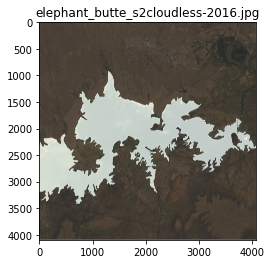

In [93]:
plt.imshow(all_images[i])
plt.title(images[i])
plt.imshow(mask, cmap='gray', alpha=0.75)

##### NWPU image labels

To get you started on the NWPU lakes dataset for model training, three files are provided with labels are provided for a total of 70 lake images (10% of the total number). These files are ```nwpu_labels\nwpu_lakes_30samples.json```, ```nwpu_labels\nwpu_lakes_20samplesA.json```, and ```nwpu_labels\nwpu_lakes_20samplesB.json```. You may use these as, respectively, train, test and validation sets, or alternatively in any way you choose. You are strongly recommended to create more of your own label images. Deep neural networks tend to work well when they have lots (and lots!) of examples to learn from.

<table style="font-size: 1em; padding: 0; margin: 0;">
<p style="border: 1px solid #ff5733; border-left: 15px solid #ff5733; padding: 10px; text-align:justify;">
    <strong style="color: #ff5733">Deliverable</strong>  
    <br/>The deliverable for Part 2 is a jupyter notebook showing a workflow to create test and training datasets, consisting of folders of imagery and corresponding label imagery, ready for training a semantic segmentation model in keras. This will mostly test your understanding the generic workflow for preparing a dataset to train and test a deep learning model, which is an essential component of the remaining Parts.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/> Going further: develop your own <br/> datasets using the sentinelsat package</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
In this section, you will create and use a geoJSON format file to A) Download satellite imagery from a specific region; B) Plot a time-series of these images; C) Merge rasters with rasterio; and D) read the merged imagery in and display side by side 
</p>
<p style="border-left: 15px solid #6019D6; padding: 0 10px; text-align:justify;">
    <strong style="color: #6019D6;">Tip.</strong> 
This section follows from the workflow introduced in "Going further:
Introduction to satellite imagery" section in Part_1_GettingStarted.ipynb
</p>
<p style="border-left: 15px solid #4E9317; padding: 0 10px; text-align:justify;">
    <strong style="color: #4E9317;">More Resources.</strong> 
<ul>
  <li><a href="https://krstn.eu/download-Sentinel-2-images/">Another guide to using sentinselsat</a></li>    
  <li><a href="https://github.com/binder-examples/getting-data/blob/master/Sentinel2.ipynb">An alternative workflow </a> to that demonstrated here is to use <a href="https://pypi.org/project/rio-tiler/">rio-tiler </a></li>
</ul>
        </tr>
        </table>

#### geoJSON

Create an account at <a href="http://geojson.io/#map=2/20.0/0.0">geojson.io</a> and log in. This is similar to what you should see:
![](https://github.com/martin-fabbri/colab-notebooks/blob/master/satellite_imagery/notebook_images/Picture1.png?raw=1)

Example: zoom into the Aral sea, on the border of Kazakhstan and Uzbekistan
![](https://github.com/martin-fabbri/colab-notebooks/blob/master/satellite_imagery/notebook_images/Picture2.png?raw=1)

Select a shape tool (polygon or rectangle) and define your area of interest. You should see JSON code on the right hand pane
![](https://github.com/martin-fabbri/colab-notebooks/blob/master/satellite_imagery/notebook_images/Picture3.png?raw=1)

In the save menu, save in geoJSON format. In the above example, your filename might be something like ```aral_sea.geojson```

#### SciHub

[Use this guide to self-registration](https://scihub.copernicus.eu/userguide/SelfRegistration) to get the access credentials you'll need to access SciHub data services for free

#### Set up your SentinelAPI oject with your SciHub credentials

In [100]:
from sentinelsat.sentinel import SentinelAPI
from sentinelsat import read_geojson, geojson_to_wkt
import os

#api_url = "https://scihub.copernicus.eu/apihub/"
api_url = "https://scihub.copernicus.eu/dhus/"

s2_api = SentinelAPI(
    user="username",
    password="password",
    api_url=api_url)

If you get download or server connection issues, try the alternative url: 
``` api_url="https://scihub.copernicus.eu/dhus/"```

#### Download imagery using your geoJSON file as an area of interest 

Download all Level 2A images collected over August 2019, with less than 10% cloud cover, and within the vicinty of the area defined in the geoJSON file


In [104]:

products = s2_api.query(
    area = geojson_to_wkt(read_geojson(poopo_geojson_path)),
    date = ("20190801", "20190901"),
    platformname = "Sentinel-2",
    processinglevel = 'Level-2A',
    cloudcoverpercentage=(0,10))

In [ ]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

poopo_geojson_path = "/content/2_Data/poopo.geojson"
api = SentinelAPI('username', 'password', 'https://scihub.copernicus.eu/dhus')
footprint = geojson_to_wkt(read_geojson(poopo_geojson_path))
products = api.query(footprint,
                     producttype='SLC',
                     orbitdirection='ASCENDING',
                     limit=1)
#api.download_all(products)
api.download("f327d870-fbf2-41f9-91b5-52ac8790b5ac")

The code below is a more detailed and specific search. Use ```s2_api.query?``` to see what these additional options mean

In [ ]:
#s2_api.query?

In [ ]:
#products = s2_api.query(
#    area = geojson_to_wkt(read_geojson('poopo.geojson')),
#    date = ("20190801", "20191201"),
#    platformname = "Sentinel-2",
#    processinglevel = 'Level-2A',
#    cloudcoverpercentage=(0,10),
#    orbitdirection='DESCENDING',
#    sensoroperationalmode='IW',
#    polarisationmode='VV')

#### Download all imagery

Warning: This will download a lot of data: 6 Sentinel-2 tiles, each over 1 GB 

In [112]:
s2_api.download_all(products)

ResultTuple(downloaded={}, retrieval_triggered={'3fb7a12a-bc83-4b10-ad26-6c1be7bb9781': {'id': '3fb7a12a-bc83-4b10-ad26-6c1be7bb9781', 'title': 'S2A_MSIL2A_20190827T143751_N0213_R096_T19KFV_20190827T200018', 'size': 1146713767, 'md5': '57C04F212742404536C16751D79F4419', 'date': datetime.datetime(2019, 8, 27, 14, 37, 51, 24000), 'footprint': 'POLYGON((-68.05496 -18.086213891930853,-67.01764 -18.078345401855554,-67.006134 -19.070127707837194,-68.04947 -19.078459430248184,-68.05496 -18.086213891930853))', 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('3fb7a12a-bc83-4b10-ad26-6c1be7bb9781')/$value", 'Online': False, 'Creation Date': datetime.datetime(2019, 8, 28, 5, 53, 22, 128000), 'Ingestion Date': datetime.datetime(2019, 8, 28, 5, 52, 59, 259000), 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('3fb7a12a-bc83-4b10-ad26-6c1be7bb9781')/Products('Quicklook')/$value"}}, failed={'0a413fcb-8d91-426a-906f-cf05a638639f': {'id': '0a413fcb-8d91-426a-906f-cf05a6

#### Work with the imagery

First load libraries for finding files by pattern matching (```glob```), zipping and unzipping files (```zipfile```), and file sysem utilities for moving and deleting files (```shutil```).

In [106]:
import glob, zipfile, shutil

Use glob to find all zip files in the current directory, and print those files to screen

In [107]:
files = glob.glob('*.zip'); print(files)

['NWPU_images.zip', 'Buscombe_liveProject_Feb2020.zip', 's2cloudless_imagery.zip']


The following will unzip each zipped file

In [108]:
def unzip_satfile(f):
    """
    f = zipped file to be extracted
    """    
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall()

Use list comprehension to unzip all files in one line of code. Warning this takes a while. Ignore a message consisting of `None` : this is normal and expected

In [109]:
[unzip_satfile(f) for f in files]

[None, None, None]

In [ ]:
# you can remove all the zipped folders to save disk space, if you have no further use of them
#[os.remove(f) for f in files]

The following function extracts only the 10-m imagery folder, moves it to the root directory, and then delete the rest of the folder

In [110]:
def tidy_folders(file):
    """
    file = root directory
    """    
    # search for the subdirectory within the GRANULE folder
    subdirec = glob.glob(file+os.sep+'GRANULE'+os.sep+'*')[0].split(os.sep)[-1]
    # the directory to move (R10m) is constructed 
    direc = file+os.sep+'GRANULE'+os.sep+subdirec+os.sep+'IMG_DATA'+os.sep+'R10m'
    # move to the root directory
    shutil.move(direc, '.')
    # rename it
    shutil.move('./R10m', file+'_R10m')
    # delete the folder
    shutil.rmtree(file, ignore_errors=True)

Finally, cycle through each of the folders and extract only the 10m imagery

In [111]:
for k in range(len(files)):
    #construct a file string 
    file = os.getcwd()+os.sep+files[k].split('.zip')[0]+'.SAFE'
    # call tidy_folders to remove unwanted imagery
    tidy_folders(file)

IndexError: ignored

The demonstrations in this project uses only 3-band visible (RGB) imagery, so to keep only that imagery and move all 6 images to 1 folder:

In [ ]:
#create a new directory with an appropriate name
os.mkdir('poopo_sentinel_RGB_20190801_20190901')

In [ ]:
for k in range(len(files)):
    file = os.getcwd()+os.sep+files[k].split('.zip')[0]+'.SAFE'
    shutil.move(glob.glob(file+'_R10m'+os.sep+'*TC*')[0], 'poopo_sentinel_RGB_20190801_20190901')

Now we can delete all the remaining image folders

In [ ]:
for k in range(len(files)):
    shutil.rmtree(os.getcwd()+os.sep+files[k].split('.zip')[0]+'.SAFE_R10m', ignore_errors=True)

##### Plot a time-series of these images

In [ ]:
import rasterio
from rasterio.merge import merge

In [ ]:
# get a list of all the jp2 files and print them to the screen
files = sorted(glob.glob('poopo_sentinel_RGB_20190801_20190901/*.jp2'))
print(files)

You can see 3 tile codes in the list: ```KFV```, ```KGU```, and ```KFV```. For visualizing a time-series, we'll want to separate those 3 groups of files

In [ ]:
# the following syntax is called 'list comprehension'
kgv = [f for f in files if f.startswith('poopo_sentinel_RGB_20190801_20190901'+os.sep+'T19KGV')]
kgu = [f for f in files if f.startswith('poopo_sentinel_RGB_20190801_20190901'+os.sep+'T19KGU')]
kfv = [f for f in files if f.startswith('poopo_sentinel_RGB_20190801_20190901'+os.sep+'T19KFV')]
print(kgv)
print(kgu)
print(kfv)

Cycle through the files and read them into an array. First we'll take a look at the size of the imagery by printing the profile of the first image in the first list

In [ ]:
with rasterio.open(kgv[0], driver='JP2OpenJPEG') as dataset:
    print(dataset.profile)

In [ ]:
# initialize empty arrays for kgv arrays and times
kgv_arrays = [] ; kgv_times = []
# cycle through each file, open file with rasterio, read it in transposed, 
# and extract the time from the filename
for k in range(len(kgv)):
    with rasterio.open(kgv[k], driver='JP2OpenJPEG') as dataset:
        # append images and image times to their respective lists
        kgv_arrays.append(dataset.read().T)
        kgv_times.append(kgv[k].split(os.sep)[-1].split('_')[1])

In [ ]:
import numpy as np
np.shape(kgv_arrays)

Now we have an array of images corresponding to the same area at different times, we can make our plot

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# call matplotlib inline to show plots in this cell output
%matplotlib inline
# visualize some of the examples
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(12,4))
for i, ax in enumerate(axs.flat):
    ax.imshow(kgv_arrays[i], cmap="gray")
    ax.set_title(kgv_times[i])

The second tile

In [ ]:
# initialize empty arrays for kgu arrays and times
kgu_arrays = [] ; kgu_times = []
for k in range(len(kgu)):
    with rasterio.open(kgu[k], driver='JP2OpenJPEG') as dataset:
        kgu_arrays.append(dataset.read().T)
        kgu_times.append(kgu[k].split(os.sep)[-1].split('_')[1])

In [ ]:
%matplotlib inline
# visualize some of the examples
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(12,4))
for i, ax in enumerate(axs.flat):
    ax.imshow(kgu_arrays[i], cmap="gray")
    ax.set_title(kgu_times[i])

And the final tile

In [ ]:
# initialize empty arrays for kfv arrays and times
kfv_arrays = [] ; kfv_times = []
for k in range(len(kfv)):
    with rasterio.open(kfv[k], driver='JP2OpenJPEG') as dataset:
        kfv_arrays.append(dataset.read().T)
        kfv_times.append(kfv[k].split(os.sep)[-1].split('_')[1])

In [ ]:
%matplotlib inline
# visualize some of the examples
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(12,4))
for i, ax in enumerate(axs.flat):
    ax.imshow(kfv_arrays[i], cmap="gray")
    ax.set_title(kfv_times[i])

##### Merge rasters with rasterio

In [ ]:
def merge_all(use, outfile):
    """
    Use = list of filenames of RGB rasters
    outfile = filename for a 8-bit image, with 3 layers, and LZW compression
              containing the merged raster
    """

    #use rasterio to open all images
    sources = [rasterio.open(path) for path in use]

    # merge the 3 images together
    dest, out_transform = merge(sources, bounds=None, res=None, precision=7)

    #save as an 8-bit image, with 3 layers, and LZW compression
    with rasterio.open(files[0]) as src:
        profile = src.profile
    profile.update({'dtype':rasterio.uint8, 'count':3, 'compress':'lzw'})

    #write the merged raster out to file
    with rasterio.open(outfile, 'w', **profile) as dst:
        dst.write(dest.astype(rasterio.uint8))

In [ ]:
# merge the first image in the sequence for each of the 3 tiles
use = list((kgv[0],kgu[0],kfv[0]))
merge_all(use, 'wholescene_'+kgu_times[0]+'.tif')

In [ ]:
# merge the second image in the sequence for each of the 3 tiles
use = list((kgv[1],kgu[1],kfv[1]))
merge_all(use, 'wholescene_'+kgu_times[1]+'.tif')

In [ ]:
# deleting unnecessary variables is a good way to manage limited memory 
del dst, src, 
del kfv_arrays, kgu_arrays, kgv_arrays

##### Read the merged imagery in and display side by side

In [ ]:
# read both datasets in as rasterio dataset objects
t1 = rasterio.open('wholescene_'+kgu_times[0]+'.tif')
t2 = rasterio.open('wholescene_'+kgu_times[1]+'.tif')

In [ ]:
#make a list of the arrays read in and transpose to flip the channels to RGB
arrays = [t1.read().T, t2.read().T]

In [ ]:
%matplotlib inline
# visualize 
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(12,4))
for i, ax in enumerate(axs.flat):
    ax.imshow(arrays[i], cmap="gray")
    ax.set_title(kgu_times[i])

##### Finally, a note about labels
If you have developed your own geospatial data sets in this way, you may find the [European Commission’s Global Surface Water Explorer](https://global-surface-water.appspot.com/) high-resolution label (“ground-truth”) data very useful. Using this dataset will likely require some familiarity with GIS such as [QGIS](https://qgis.org/en/site/) or geospatial processing such as [GDAL for python](https://pypi.org/project/GDAL/)